In [1]:
# !pip install chess cairosvg diffusers transformers accelerate

# Libraries Used

In [2]:
import chess
import random
import chess.svg
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    DDPMScheduler,
    AutoencoderKL,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
import os
import gc
import cairosvg 

# Dataset Creation

### Some Handy Data Parameters

In [3]:
MODEL_ID = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "chess_diffusion_output"
IMAGE_SIZE = 512
BATCH_SIZE = 5 
NUM_EPOCHS = 15 
LEARNING_RATE = 1e-5
NUM_GAMES_DATASET = 30 
VALIDATION_SAMPLES = 5 
SAVE_EPOCH_INTERVAL = 5 
MAX_SEQ_FRAMES_CONTEXT = 5 
N_GAMES_TO_LOAD = 3  

### Hardware Device Selection

In [4]:
if torch.cuda.is_available():
    device = "cuda"
    torch_dtype = torch.float16 
else:
    device = "cpu"
    torch_dtype = torch.float32

print(f"Using device: {device}")
print(f"Using dtype: {torch_dtype}")

Using device: cpu
Using dtype: torch.float32


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "models"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "images"), exist_ok=True)

In [6]:
def generate_random_chess_game():
    """Generate a sequence of legal moves for a random chess game."""
    board = chess.Board()
    game_moves = []
    while not board.is_game_over(claim_draw=True):
        legal_moves = list(board.legal_moves)
        if not legal_moves:
            break
        move = random.choice(legal_moves)
        game_moves.append(move.uci())
        board.push(move)
    return game_moves

def svg_to_pil(svg_code, output_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """Converts SVG string to a PIL Image."""
    try:
        png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
        image = Image.open(BytesIO(png_data)).convert("RGB")
        image = image.resize(output_size, Image.Resampling.LANCZOS)
        return image
    except Exception as e:
        print(f"Error converting SVG to PIL: {e}")
        return Image.new("RGB", output_size, (128, 128, 128)) 

def generate_chess_dataset(num_games=NUM_GAMES_DATASET, max_seq_frames=MAX_SEQ_FRAMES_CONTEXT, save_dir="chess_diffusion_output/games"):
    """Generates chess dataset and saves each game's data individually to avoid memory issues."""
    os.makedirs(save_dir, exist_ok=True)
    print(f"Generating {num_games} chess games for dataset...")

    total_samples = 0

    for game_idx in tqdm(range(num_games), desc="Generating Games"):
        print(f"\nGenerating game {game_idx + 1}/{num_games}...")
        moves = generate_random_chess_game()
        print(f"Game {game_idx + 1} has {len(moves)} moves.")
        
        board = chess.Board()
        game_data = []

        initial_svg = chess.svg.board(board=board)
        initial_frame_pil = svg_to_pil(initial_svg)

        gray_image = Image.new("RGB", initial_frame_pil.size, (128, 128, 128))
        context = [gray_image.copy() for _ in range(max_seq_frames)]

        game_data.append({
            "previous_frames_pil": context.copy(),
            "action": "chess",
            "target_frame_pil": initial_frame_pil,
            "move_number": 0,
        })

        context.pop(0)
        context.append(initial_frame_pil)

        for move_num, move in enumerate(moves):
            try:
                board.push_uci(move)
            except ValueError:
                print(f"Skipping invalid move {move} in game {game_idx + 1}")
                continue

            new_svg = chess.svg.board(board=board)
            new_frame_pil = svg_to_pil(new_svg)

            game_data.append({
                "previous_frames_pil": context.copy(),
                "action": move,
                "target_frame_pil": new_frame_pil,
                "move_number": move_num + 1,
            })

            context.pop(0)
            context.append(new_frame_pil)

        save_path = os.path.join(save_dir, f"game_{game_idx + 1}.pth")
        torch.save(game_data, save_path)
        print(f"Saved game {game_idx + 1} with {len(game_data)} samples to {save_path}")

        total_samples += len(game_data)

        del game_data
        torch.cuda.empty_cache()

    print(f"\n✅ Generated total {total_samples} samples across {num_games} games.")


In [14]:
if __name__ == "__main__":
    OUTPUT_DIR = "chess_diffusion_output"
    game_dir = os.path.join(OUTPUT_DIR, "games")

    chess_data = []  

    if os.path.exists(game_dir) and os.listdir(game_dir):
        print(f"Loading up to {N_GAMES_TO_LOAD} game files from {game_dir}...")
        game_files = sorted([f for f in os.listdir(game_dir) if f.endswith(".pth")])

        for gf in tqdm(game_files[:N_GAMES_TO_LOAD], desc="Loading Selected Games"):
            game_path = os.path.join(game_dir, gf)
            game_data = torch.load(game_path)
            chess_data.append(game_data) 

        total_samples = sum(len(game) for game in chess_data)
        print(f"Loaded {len(chess_data)} games with {total_samples} total samples.")

    else:
        print("No game data found. Generating dataset...")
        generate_chess_dataset(save_dir=game_dir)
        print("Dataset generation complete. Please rerun the script to load the data.")


Loading up to 3 game files from chess_diffusion_output/games...


Loading Selected Games:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded 3 games with 825 total samples.


In [15]:
import matplotlib.pyplot as plt

def show_image(img, title=""):
    """Display a single image with a title."""
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

def display_game_data(chess_data, game_index=1, num_samples=6):
    """
    Display data for a specific game.

    Parameters:
    - chess_data: List containing game datasets.
    - game_index: Index of the game to display.
    - num_samples: Number of samples to display from the selected game.
    """
    if game_index >= len(chess_data):
        print(f"Invalid game index. Please select a value between 0 and {len(chess_data) - 1}.")
        return

    game_data = chess_data[game_index]
    total_samples = len(game_data)
    print(f"\nTotal samples in selected game: {total_samples}\n")

    num_samples = min(num_samples, total_samples)

    for i in range(num_samples):
        sample = game_data[i]
        print(f"\n--- Sample {i + 1} ---")
        print(f"Move Number: {sample['move_number']}")
        print(f"Action (Move Token): {sample['action']}")
        print(f"Number of Previous Frames: {len(sample['previous_frames_pil'])}")

        for j, frame in enumerate(sample['previous_frames_pil']):
            show_image(frame, title=f"Previous Frame {j + 1}")

        show_image(sample['target_frame_pil'], title="Target Frame")



Total samples in selected game: 110


--- Sample 1 ---
Move Number: 0
Action (Move Token): chess
Number of Previous Frames: 5


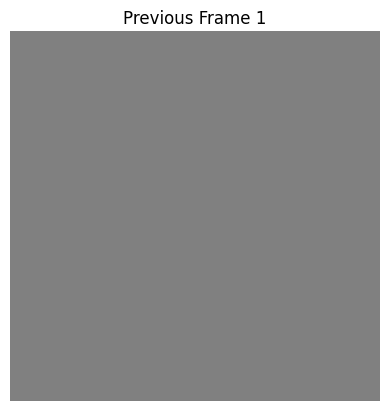

In [16]:
display_game_data(chess_data, game_index=0, num_samples=6)
